In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, silhouette_samples
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Crear sesión Spark optimizada para ML
spark = SparkSession.builder \
    .appName("KMeans_Cundinamarca") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# Configurar nivel de log para reducir ruido
spark.sparkContext.setLogLevel("WARN")

print("✅ Sesión Spark iniciada exitosamente")
print(f"📊 Versión Spark: {spark.version}")
print(f"🖥️  Spark UI disponible en: {spark.sparkContext.uiWebUrl}")

✅ Sesión Spark iniciada exitosamente
📊 Versión Spark: 3.5.1
🖥️  Spark UI disponible en: http://0709d2530409:4040


In [ ]:

df_spark = spark.read.option("header", True).option("inferSchema", True).csv("base_reducida (1).csv")

# Renombrar columnas con espacios o caracteres conflictivos
df_spark = df_spark.selectExpr([
    "`TOTAL INSCRITOS` as TOTAL_INSCRITOS",
    "`TOTAL EVALUADOS` as TOTAL_EVALUADOS",
    "`No. ACCESOS FIJOS A INTERNET` as ACCESOS_INTERNET",
    "`POBLACIÓN DANE` as POBLACION_DANE",
    "`COBERTURA_NETA` as COBERTURA_NETA",
    "`APROBACIÓN` as APROBACION",
    "`REPITENCIA` as REPITENCIA",
    "`DESERCIÓN` as DESERCION",
    "`INDICE TOTAL` as INDICE_TOTAL"
])


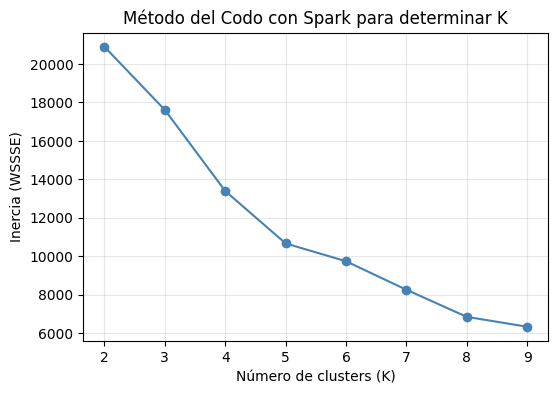

In [ ]:

# MÉTODO DEL CODO



# Variables a usar en clustering
variables_cluster = [
    'TOTAL_INSCRITOS', 'TOTAL_EVALUADOS', 'ACCESOS_INTERNET',
    'POBLACION_DANE', 'COBERTURA_NETA', 'APROBACION',
    'REPITENCIA', 'DESERCION'
]


# Rellenar nulos con la mediana (por columna)
for col_name in variables_cluster:
    mediana = df_spark.approxQuantile(col_name, [0.5], 0.001)[0]
    df_spark = df_spark.fillna({col_name: mediana})

# Vectorizar columnas numéricas
assembler = VectorAssembler(inputCols=variables_cluster, outputCol="features_raw")
df_vector = assembler.transform(df_spark)

# Escalar usando StandardScaler
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
df_scaled = scaler.fit(df_vector).transform(df_vector)

# Método del codo: evaluar inercia (WSSSE) para diferentes valores de k
inercia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    modelo = kmeans.fit(df_scaled)
    wssse = modelo.summary.trainingCost  # equivalente a inertia_
    inercia.append(wssse)

# Visualizar el codo (requiere matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(K_range, inercia, 'o-', color='steelblue')
plt.title('Método del Codo con Spark para determinar K')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia (WSSSE)')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.show()



In [ ]:

# K-MEANS EDUCATIVO CON SPARK SQL (Versión Simplificada)

from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType
from sklearn.metrics import davies_bouldin_score, silhouette_samples
import pandas as pd
import numpy as np

# CARGA DE DATOS Y RENOMBRAR COLUMNAS
df_spark = spark.read.option("header", True).option("inferSchema", True).csv("base_reducida (1).csv")
df_spark = df_spark.selectExpr([
    "`TOTAL INSCRITOS` as TOTAL_INSCRITOS",
    "`TOTAL EVALUADOS` as TOTAL_EVALUADOS",
    "`No. ACCESOS FIJOS A INTERNET` as ACCESOS_INTERNET",
    "`POBLACIÓN DANE` as POBLACION_DANE",
    "`COBERTURA_NETA` as COBERTURA_NETA",
    "`APROBACIÓN` as APROBACION",
    "`REPITENCIA` as REPITENCIA",
    "`DESERCIÓN` as DESERCION",
    "`INDICE TOTAL` as INDICE_TOTAL"
])

variables_cluster = [
    'TOTAL_INSCRITOS', 'TOTAL_EVALUADOS', 'ACCESOS_INTERNET',
    'POBLACION_DANE', 'COBERTURA_NETA', 'APROBACION',
    'REPITENCIA', 'DESERCION'
]

# Rellenar nulos con la mediana por variable
for col_name in variables_cluster:
    mediana = df_spark.approxQuantile(col_name, [0.5], 0.01)[0]
    df_spark = df_spark.fillna({col_name: mediana})

# Vectorizar y escalar
assembler = VectorAssembler(inputCols=variables_cluster, outputCol="features_raw")
df_vector = assembler.transform(df_spark)

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
df_scaled = scaler.fit(df_vector).transform(df_vector)

# === K-MEANS CON INICIALIZACION MULTIPLE ===
k = 3
n_inits = 50
best_score = -1
results = []

for seed in range(n_inits):
    kmeans = KMeans(featuresCol="features", k=k, seed=seed)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    score = evaluator.evaluate(predictions)
    results.append((seed, score))

    if score > best_score:
        best_score = score
        best_model = model
        best_predictions = predictions
        best_seed = seed

# Convertir resultados a DataFrame
schema = ["Seed", "Silhouette"]
df_resultados = spark.createDataFrame(results, schema=schema).orderBy(col("Silhouette").desc())
print("TOP 5 RESULTADOS POR SILHOUETTE:")
df_resultados.show(5, truncate=False)

# === METRICAS FINALES ===
best_predictions = best_predictions.withColumnRenamed("prediction", "Cluster")
best_predictions.createOrReplaceTempView("clustered")

X_pandas = df_scaled.select("features").rdd.map(lambda row: row.features.toArray()).collect()
labels_pandas = best_predictions.select("Cluster").rdd.map(lambda row: row[0]).collect()
sil_samples = silhouette_samples(np.array(X_pandas), np.array(labels_pandas))

ch_score = best_model.summary.trainingCost
db_score = davies_bouldin_score(X_pandas, labels_pandas)

# Calcular silhouette del modelo básico
kmeans_basico = KMeans(featuresCol="features", k=k, seed=42)
modelo_basico = kmeans_basico.fit(df_scaled)
preds_basico = modelo_basico.transform(df_scaled)
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_basico = evaluator.evaluate(preds_basico)

print(f"Mejor Silhouette: {best_score:.3f} (Seed: {best_seed})")
print(f"Calinski-Harabasz (proxy): {ch_score:.1f}")
print(f"Davies-Bouldin: {db_score:.3f}")

# === EXPORTACION DE RESULTADOS ===
best_predictions.select(variables_cluster + ["INDICE_TOTAL", "Cluster"]).write.mode("overwrite").option("header", True).csv("df_clusters_spark.csv")
df_resultados.write.mode("overwrite").option("header", True).csv("resultados_silhouette_spark.csv")

metricas_schema = StructType([
    StructField("Silhouette_Optimizado", DoubleType(), True),
    StructField("Silhouette_Basico", DoubleType(), True),
    StructField("Calinski_Harabasz", DoubleType(), True),
    StructField("Davies_Bouldin", DoubleType(), True),
    StructField("Mejor_Seed", IntegerType(), True)
])

metricas_data = [{
    'Silhouette_Optimizado': float(best_score),
    'Silhouette_Basico': float(silhouette_basico),
    'Calinski_Harabasz': float(ch_score),
    'Davies_Bouldin': float(db_score),
    'Mejor_Seed': int(best_seed)
}]

df_metricas = spark.createDataFrame(metricas_data, schema=metricas_schema)
df_metricas.write.mode("overwrite").option("header", True).csv("metricas_resumen_spark.csv")

print("Archivos exportados:")
print("   - df_clusters_spark.csv")
print("   - metricas_resumen_spark.csv")
print("   - resultados_silhouette_spark.csv")


TOP 5 RESULTADOS POR SILHOUETTE:
+----+------------------+
|Seed|Silhouette        |
+----+------------------+
|1   |0.5678581455240389|
|32  |0.5678581455240389|
|18  |0.5678581455240389|
|33  |0.5678581455240389|
|41  |0.5678581455240389|
+----+------------------+
only showing top 5 rows

Mejor Silhouette: 0.568 (Seed: 1)
Calinski-Harabasz (proxy): 16872.9
Davies-Bouldin: 1.074
Archivos exportados:
   - df_clusters_spark.csv
   - metricas_resumen_spark.csv
   - resultados_silhouette_spark.csv


In [ ]:

best_predictions.createOrReplaceTempView("clustered")

# Consulta SQL: promedios por cluster redondeados
spark.sql("""
    SELECT
        Cluster,
        ROUND(AVG(ACCESOS_INTERNET), 2) AS Accesos_Internet,
        ROUND(AVG(POBLACION_DANE), 2) AS Poblacion,
        ROUND(AVG(COBERTURA_NETA), 2) AS Cobertura,
        ROUND(AVG(APROBACION), 2) AS Aprobacion,
        ROUND(AVG(REPITENCIA), 2) AS Repitencia,
        ROUND(AVG(DESERCION), 2) AS Desercion,
        ROUND(AVG(INDICE_TOTAL), 2) AS Indice_Total
    FROM clustered
    GROUP BY Cluster
    ORDER BY Cluster
""").show()


+-------+----------------+---------+---------+----------+----------+---------+------------+
|Cluster|Accesos_Internet|Poblacion|Cobertura|Aprobacion|Repitencia|Desercion|Indice_Total|
+-------+----------------+---------+---------+----------+----------+---------+------------+
|      0|        128998.0| 688156.0|    88.73|     93.25|      3.01|     3.55|        0.68|
|      1|         8078.85| 47737.04|    93.01|     92.97|      3.45|     3.21|        0.66|
|      2|        31826.72|170887.63|    95.44|     91.67|      3.63|      3.5|         0.7|
+-------+----------------+---------+---------+----------+----------+---------+------------+



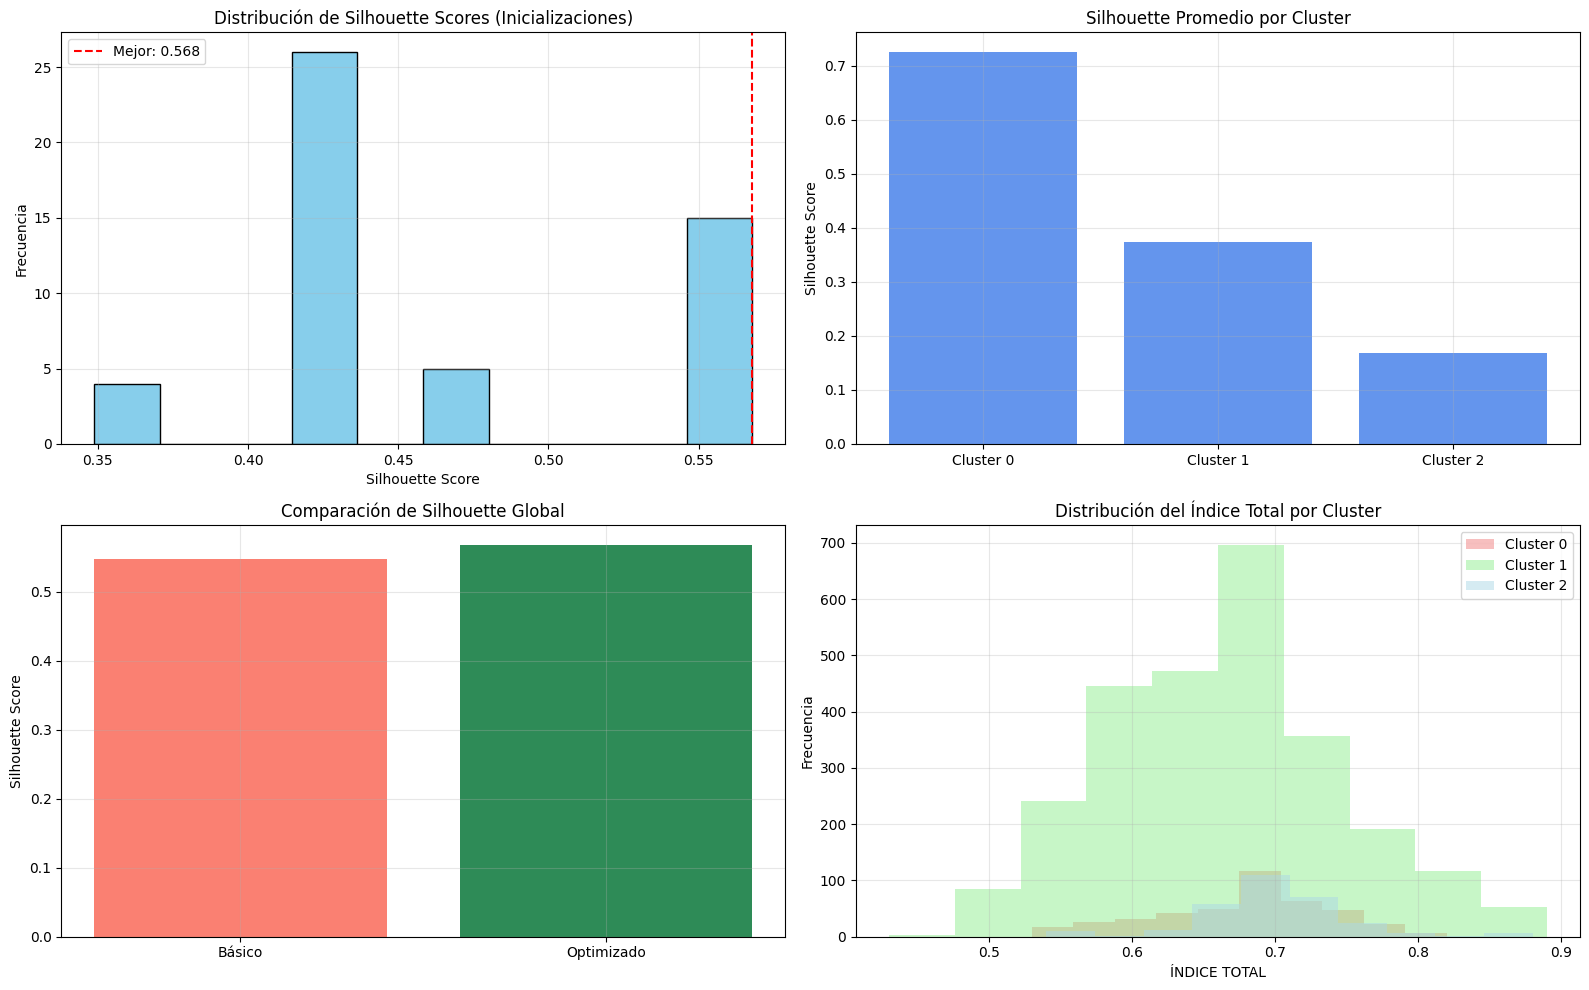

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples

# Convertir a pandas
df_resultados_pd = df_resultados.toPandas()
df_clusters_pd = best_predictions.select("Cluster", "INDICE_TOTAL", *variables_cluster).toPandas()

# Extraer features y etiquetas
X = df_scaled.select("features").rdd.map(lambda row: row["features"].toArray()).collect()
labels = best_predictions.select("Cluster").rdd.map(lambda row: row["Cluster"]).collect()

# Calcular silhouette por muestra
sil_samples = silhouette_samples(np.array(X), np.array(labels))
df_sil = pd.DataFrame({'Cluster': labels, 'Silhouette': sil_samples})
cluster_means = df_sil.groupby("Cluster")["Silhouette"].mean()

#ISUALIZACIONES
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# 1. Histograma de Silhouette Scores
axs[0, 0].hist(df_resultados_pd["Silhouette"], bins=10, color='skyblue', edgecolor='black')
axs[0, 0].axvline(df_resultados_pd["Silhouette"].max(), color='red', linestyle='--', label=f'Mejor: {df_resultados_pd["Silhouette"].max():.3f}')
axs[0, 0].set_title('Distribución de Silhouette Scores (Inicializaciones)')
axs[0, 0].set_xlabel('Silhouette Score')
axs[0, 0].set_ylabel('Frecuencia')
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# 2. Silhouette real por Cluster
axs[0, 1].bar([f'Cluster {i}' for i in cluster_means.index], cluster_means.values, color='cornflowerblue')
axs[0, 1].set_title('Silhouette Promedio por Cluster')
axs[0, 1].set_ylabel('Silhouette Score')
axs[0, 1].grid(True, alpha=0.3)

# 3. Comparación básico vs optimizado
axs[1, 0].bar(['Básico', 'Optimizado'], [silhouette_basico, best_score], color=['salmon', 'seagreen'])
axs[1, 0].set_title('Comparación de Silhouette Global')
axs[1, 0].set_ylabel('Silhouette Score')
axs[1, 0].grid(True, alpha=0.3)

# 4. Distribución del Índice Total por cluster
colors = ['lightcoral', 'lightgreen', 'lightblue']
for i in sorted(df_clusters_pd["Cluster"].unique()):
    axs[1, 1].hist(df_clusters_pd[df_clusters_pd["Cluster"] == i]['INDICE_TOTAL'], bins=10,
                   alpha=0.5, label=f'Cluster {i}', color=colors[i % len(colors)])
axs[1, 1].set_title('Distribución del Índice Total por Cluster')
axs[1, 1].set_xlabel('ÍNDICE TOTAL')
axs[1, 1].set_ylabel('Frecuencia')
axs[1, 1].legend()
axs[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


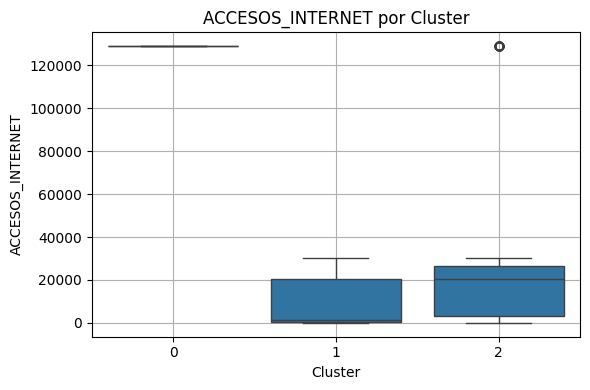

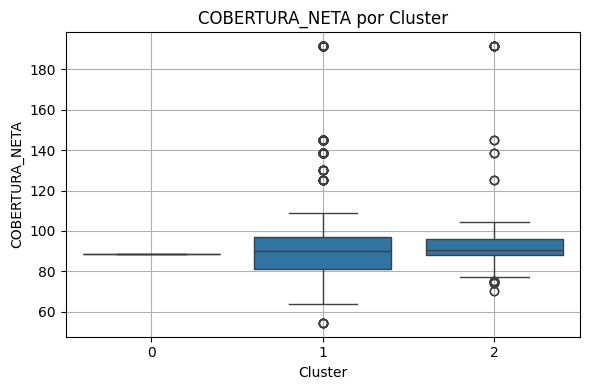

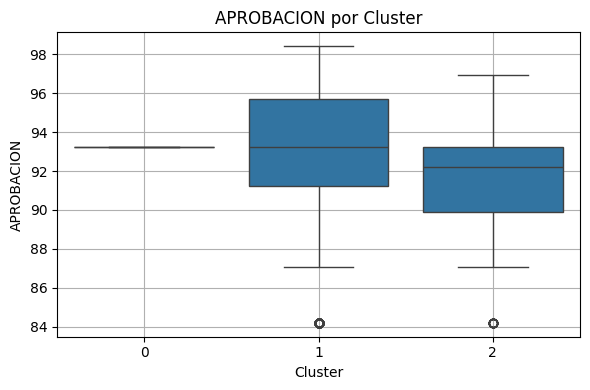

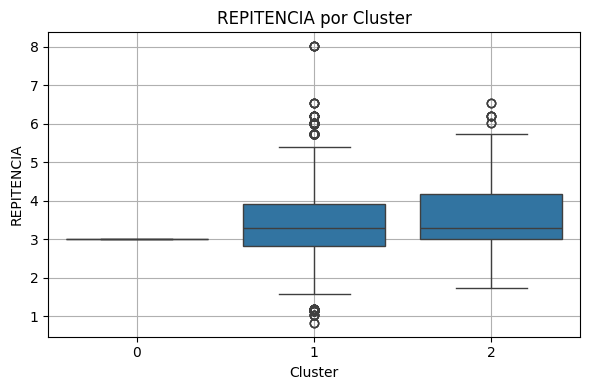

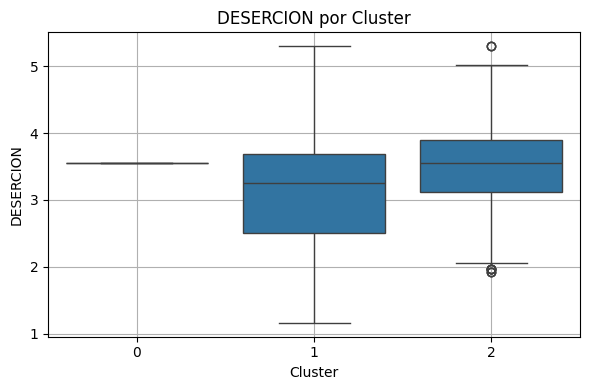

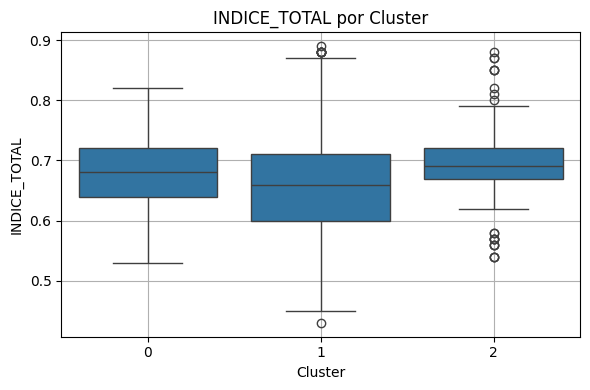

In [ ]:


variables = [
    'ACCESOS_INTERNET', 'COBERTURA_NETA',
    'APROBACION', 'REPITENCIA', 'DESERCION', 'INDICE_TOTAL'
]

# Convertir a Pandas
df_clusters_pd = best_predictions.select("Cluster", *variables).toPandas()

for var in variables:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_clusters_pd, x='Cluster', y=var)
    plt.title(f'{var} por Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



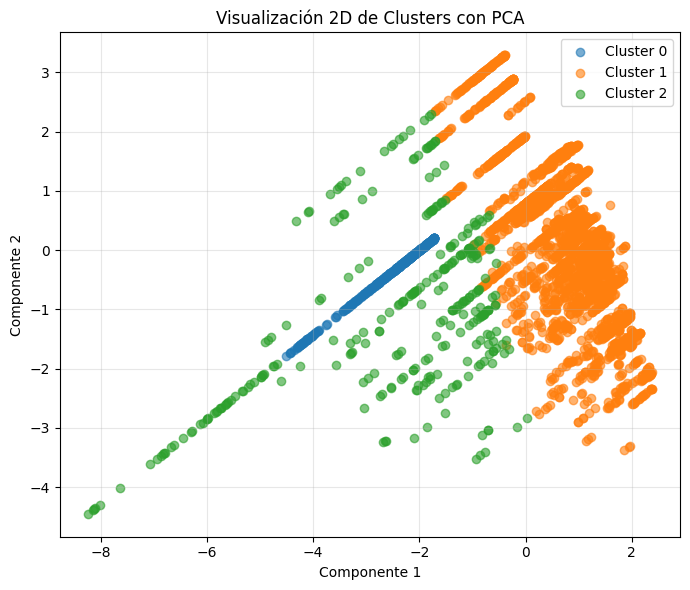

In [ ]:
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Aplicar PCA para reducir a 2D
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Añadir los clusters del mejor modelo
df_clustered = best_model.transform(df_pca).withColumnRenamed("prediction", "Cluster")

# Convertir a Pandas para graficar
df_plot = df_clustered.select("pca_features", "Cluster").toPandas()
df_plot[["x", "y"]] = df_plot["pca_features"].apply(lambda vec: pd.Series(vec.toArray()))

# Graficar
plt.figure(figsize=(7, 6))
for cluster_id in sorted(df_plot["Cluster"].unique()):
    subset = df_plot[df_plot["Cluster"] == cluster_id]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.title("Visualización 2D de Clusters con PCA")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Estrategias para responder las preguntas del negocio

## En lugar de analizar variables aisladas, K-means identifica combinaciones de factores que caracterizan diferentes tipos de municipios

## Revela que conectividad, demografía y variables educativas interactúan de formas específicas en cada cluster